In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import torch
import transformers
from transformers import BertForTokenClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup

!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange
import torch.optim as optim
from seqeval.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

MAX_LEN = 75
bs = 32
epochs = 7
max_grad_norm = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

transformers.__version__
torch.__version__

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=336d69363b93bab5efab7d111e01da03983a8e5b25e7e6540e75ec23957ebafb
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
Successfully built seqeval


In [2]:
train = pd.read_csv("/kaggle/input/voc-processed-data/train-nl.tsv", sep="\t")
len(train)

359695

In [3]:
train.head()

,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# language = nl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,# document_path = ../data/annotated_data/A/NL-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,heste,O,O,O,O,O,O,_
4,afschrift,O,O,O,O,O,O,_


It is worth noting that the data is imbalanced, with the "O" label being significantly more frequent than the named entity labels. This may impact the performance of a machine learning model trained on this data, as the model may have a bias towards predicting the "O" label due to its higher frequency in the data.

https://spraakbanken.gu.se/sites/default/files/2022/SLTC-2020_paper_4.pdf this paper trained ML models with both undersampling as oversampling techniques and got the highest score for oversampling. thus we will also use this tenchnique

In [4]:
df = train
df['DOC PATH'] = df['TOKEN'].str.extract(r'# document_path = (.*)', expand=False).ffill()

In [5]:
# Move Sentence # to the front
sentence_col = df.pop('DOC PATH')
df.insert(0, 'DOC PATH', sentence_col)

df = df.dropna()
print(df.isnull().sum())
# df = df.dropna(subset=["NE-MAIN"])
# df = df.dropna(subset=["TOKEN"])

df.head()

DOC PATH               0
TOKEN                  0
NE-MAIN                0
NE-PER-NAME            0
NE-PER-GENDER          0
NE-PER-LEGAL-STATUS    0
NE-PER-ROLE            0
NE-ORG-BENEFICIARY     0
MISC                   0
dtype: int64


,DOC PATH,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
3,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,heste,O,O,O,O,O,O,_
4,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,afschrift,O,O,O,O,O,O,_
5,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,m,O,O,O,O,O,O,_
6,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,In,O,O,O,O,O,O,_
7,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,den,O,O,O,O,O,O,_


In [6]:
counts = df['NE-MAIN'].value_counts()

# Create a dictionary mapping each class to its count
class_counts = {cls: count for cls, count in zip(counts.index, counts.values)}
class_counts

{'O': 321259,
 'I-Person': 15444,
 'B-Person': 8216,
 'I-Place': 3766,
 'B-Place': 2856,
 'I-Organization': 2155,
 'B-Organization': 741,
 'I-Organization,B-Place': 208,
 'I-Organization,I-Place': 111,
 'I-Person,B-Place': 105,
 'I-Person,I-Place': 54,
 'B-Organization,I-Place': 25,
 'B-Person,I-Place': 19,
 'I-Organization,I-Person': 4,
 'B-Organization,B-Place': 2,
 'B-Person,B-Place': 2,
 'B-Organization,I-Person': 1,
 'I-Organization,I-Person,B-Place': 1,
 'I-Organization,I-Person,I-Place': 1}

https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf

In [ ]:
# Define the under-sampler and over-sampler
# under_sampler = RandomUnderSampler(sampling_strategy={'O': 321259,
#  'I-Person': 15444,
#  'B-Person': 8216,
#  'I-Place': 3766,
#  'B-Place': 2856,
#  'I-Organization': 2155,
#  'B-Organization': 741,
#  'I-Organization,B-Place': 208,
#  'I-Organization,I-Place': 111,
#  'I-Person,B-Place': 105,
#  'I-Person,I-Place': 54,
#  'B-Organization,I-Place': 25,
#  'B-Person,I-Place': 19,
#  'I-Organization,I-Person': 4,
#  'B-Organization,B-Place': 2,
#  'B-Person,B-Place': 2,
#  'B-Organization,I-Person': 1,
#  'I-Organization,I-Person,B-Place': 1,
#  'I-Organization,I-Person,I-Place': 1})

over_sampler = RandomOverSampler(sampling_strategy="not majority") # Randomly over-sample minority class to have 50% of majority class

# Apply the over-sampler and under-sampler to the training data
X_train = df.drop(columns=['NE-MAIN'])
y_train = df['NE-MAIN']

# First, under-sample the majority class
# X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
# Then, over-sample the minority class on the under-sampled data
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

# Convert the resampled data back to a dataframe
df_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [ ]:
df_resampled.columns

In [ ]:
df_resampled['NE-MAIN'].value_counts()

In [ ]:
# df[(df != 'O').all(axis=1)]

In [ ]:
# df[(df.iloc[:, :-3] != 'O').all(axis=1)]

In [7]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["TOKEN"].values.tolist(),
                                                     s["NE-MAIN"].values.tolist())]
        self.grouped = self.data.groupby("DOC PATH").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(df)

In [9]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]

The sentences are annotated with the BIO-schema and the labels look like this.

In [10]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person', 'I-Person', 'I-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Place', 'I-Place', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-P

In [12]:
tag_values = list(set(df["NE-MAIN"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [13]:
tag2idx

{'I-Person,B-Place': 0,
 'B-Organization,B-Place': 1,
 'I-Person': 2,
 'I-Place': 3,
 'B-Organization,I-Place': 4,
 'B-Person,I-Place': 5,
 'I-Organization,I-Person,I-Place': 6,
 'B-Person,B-Place': 7,
 'I-Organization': 8,
 'I-Person,I-Place': 9,
 'B-Place': 10,
 'B-Person': 11,
 'O': 12,
 'I-Organization,I-Place': 13,
 'I-Organization,I-Person': 14,
 'I-Organization,I-Person,B-Place': 15,
 'B-Organization,I-Person': 16,
 'B-Organization': 17,
 'I-Organization,B-Place': 18,
 'PAD': 19}

In [14]:
def get_tag_distribution(df, tag_col):
    tag_distribution = df.groupby(tag_col).size().reset_index(name='counts')
    tag_distribution = tag_distribution.sort_values('counts', ascending=False)
    tag_distribution['percentage'] = (tag_distribution['counts'] / tag_distribution['counts'].sum()) * 100
    return tag_distribution

columns = ['NE-MAIN', 'NE-PER-NAME', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'NE-ORG-BENEFICIARY', 'MISC']
for col in columns:
    print(f"Tag distribution for {col}:")
    print(get_tag_distribution(df, col))
    print()

Tag distribution for NE-MAIN:
                            NE-MAIN  counts  percentage
18                                O  321259   90.503141
14                         I-Person   15444    4.350790
4                          B-Person    8216    2.314562
17                          I-Place    3766    1.060935
7                           B-Place    2856    0.804575
8                    I-Organization    2155    0.607094
0                    B-Organization     741    0.208750
9            I-Organization,B-Place     208    0.058597
13           I-Organization,I-Place     111    0.031270
15                 I-Person,B-Place     105    0.029580
16                 I-Person,I-Place      54    0.015213
3            B-Organization,I-Place      25    0.007043
6                  B-Person,I-Place      19    0.005353
10          I-Organization,I-Person       4    0.001127
5                  B-Person,B-Place       2    0.000563
1            B-Organization,B-Place       2    0.000563
11  I-Organization

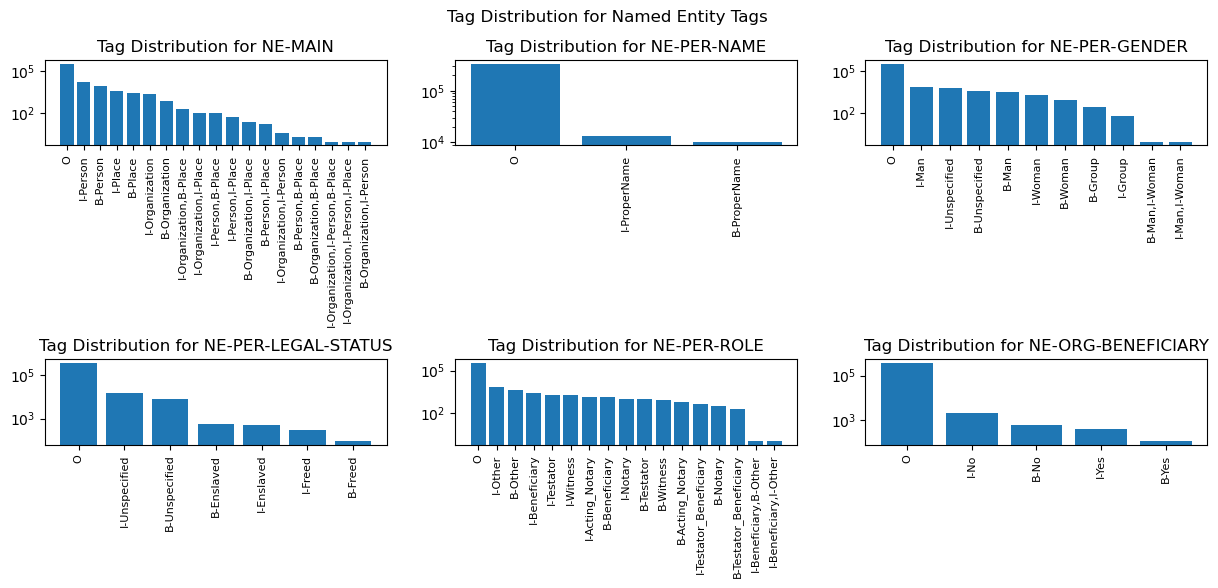

In [52]:
# define columns
columns = ['NE-MAIN', 'NE-PER-NAME', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'NE-ORG-BENEFICIARY']

# create a subplot with multiple plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

# loop over columns and plot tag distribution for each column
for idx, col in enumerate(columns):
    row_idx = idx // 3
    col_idx = idx % 3
    ax = axs[row_idx, col_idx]
    tag_distribution = get_tag_distribution(df, col)
    ax.bar(tag_distribution[col], tag_distribution['counts'])
    ax.set_xticklabels(tag_distribution[col], rotation=90)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_title(f"Tag Distribution for {col}")
    ax.set_yscale('log')

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=2.5)

# set overall title for the figure
fig.suptitle("Tag Distribution for Named Entity Tags")

# show the plot
plt.show()

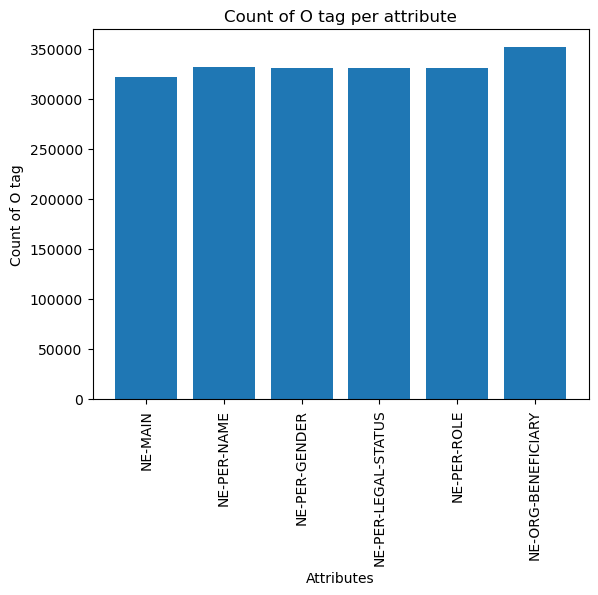

In [56]:
import matplotlib.pyplot as plt

# create a dictionary to store the tag counts for each column
tag_counts = {}
for col in df.columns[2:-1]:
    tag_counts[col] = df[df[col] == 'O'][col].count()

# create a bar plot to show the tag counts
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Count of O tag')
plt.title('Count of O tag per attribute')
plt.show()

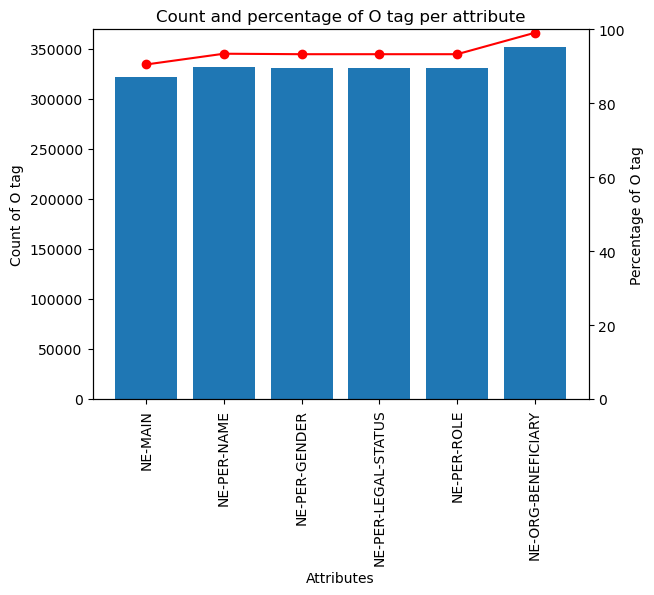

In [57]:
import matplotlib.pyplot as plt

# create a dictionary to store the tag counts and percentages for each column
tag_counts = {}
for col in df.columns[2:-1]:
    total_count = df[col].count()
    o_count = df[df[col] == 'O'][col].count()
    o_percentage = (o_count / total_count) * 100
    tag_counts[col] = {'count': o_count, 'percentage': o_percentage}

# create a bar plot to show the tag counts and percentages
plt.bar(tag_counts.keys(), [x['count'] for x in tag_counts.values()])
plt.xticks(rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Count of O tag')
plt.title('Count and percentage of O tag per attribute')
ax = plt.gca().twinx()
ax.plot(tag_counts.keys(), [x['percentage'] for x in tag_counts.values()], color='red', marker='o')
ax.set_ylabel('Percentage of O tag')
ax.set_ylim([0, 100])
plt.show()

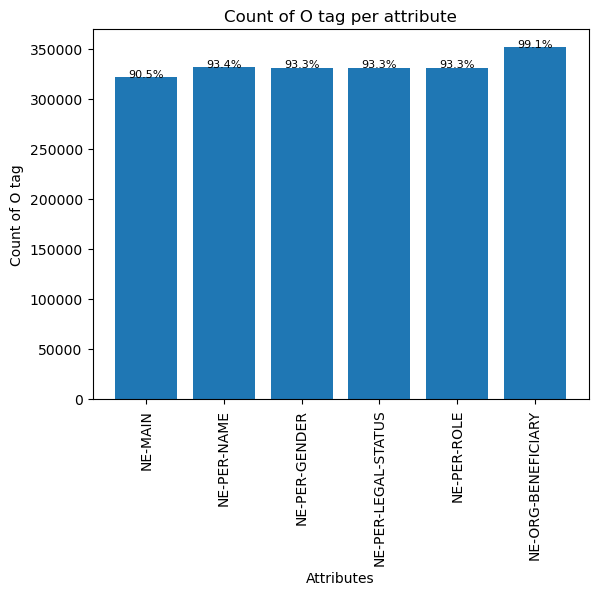

In [67]:
import matplotlib.pyplot as plt

# create a dictionary to store the tag counts for each column
tag_counts = {}
for col in df.columns[2:-1]:
    tag_counts[col] = df[df[col] == 'O'][col].count()

# create a bar plot to show the tag counts
plt.bar(list(tag_counts.keys()), tag_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Count of O tag')
plt.title('Count of 'O' Tag Occurrence + percentage over total per Attribute')

# add percentage labels to the bars
for i, count in enumerate(tag_counts.values()):
    plt.text(i, count + 100, f"{count/len(df)*100:.1f}%", ha='center', fontsize=8)

plt.show()


In [ ]:
classes = list(filter(lambda x: x not in ["O", np.nan], list(df_resampled["NE-MAIN"].unique())))
print(classes)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('GroNLP/bert-base-dutch-cased', do_lower_case=False) #bert-base-cased

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "GroNLP/bert-base-dutch-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = optim.AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
valid_seq_lens = []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    seq_lens = b_input_mask.sum(dim=1).tolist()
    valid_seq_lens.extend(seq_lens)

In [ ]:
def nested_list(lst, seq_lens):
    nested = []
    i = 0
    for seq_len in seq_lens:
        nested.append(lst[i:i+seq_len])
        i += seq_len
    return nested

In [ ]:
valid_seq_lens = [int(x) for x in valid_seq_lens]

In [ ]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    model.train()
    total_loss = 0
    total_precision = 0
    total_recall = 0
    total_samples = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    loss_values.append(avg_train_loss)
    
#     == EVAL ==
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    for p, l in zip(predictions, true_labels):
        for p_i, l_i in zip(p, l):
            if tag_values[l_i] != "PAD" and l_i >= len(tag_values):
                print("Problematic index:", l_i)
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    
    pred_tags_nested = nested_list(pred_tags,valid_seq_lens)
    valid_tags_nested = nested_list(valid_tags,valid_seq_lens)    
    report = classification_report(valid_tags_nested, pred_tags_nested, digits=4)
    print(report)
    
    print()

Really high accuracy but very low f1 score = This could indicate underfitting on an unbalanced dataset.

Take a case of binary classification for example. You have 100 testing examples. 82 of them are from class A and the other 18 are from class B. Your model can achieve 82% accuracy simply by classifying A each time! Such is why the F1 score is so important in evaluating models on unbalanced datasets; it accounts for the performance of all classes.

There are two things you may research to improve your model.

Modify your model
Balance your dataset to improve data quality

https://arxiv.org/pdf/1601.04756.pdf --> Between the two techniques (RO and RU), the results also showed that RO is preferable. The reason of this is obvious, since RU removes instances of the majority class, as the classifier is generated, it missed important concepts about the majority class resulting to a better performance on some minority classes but jeopardized performance on the major- ity class.

In [ ]:
report_ = classification_report(valid_tags_nested, pred_tags_nested, digits=4,output_dict=True)
sns.heatmap(pd.DataFrame(report_).iloc[:-1, :].T, annot=True)

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Apply the model to a new sentence


In [ ]:
# https://zoekintranscripties.nl/document/NL-HaNA/1.04.02/7780/0017?index=9
test_sentence = """
twee agter den anderen gesk: verklaringen van den bootsman
en gew: opsiender der Equipagie goederen tot Japara Jan
fransz: van amsterdam, wegens de aenhalingh van 3.
picols amphioen tot damack door den fiscael willem
drost en het overbrengen denselve tot Japara, mitsgaders het
bergen ofte opslaen van de bewuste 86. Canassers aenge„
haelden amphioen van den Engelsman griffit inde
woninge van den gew: gesaghebber goodschalk
beandwoorde interrogaterium door gem: bootsman Jan
france, over de voorsz. 86. Canassers amphioen —
verklaringe vanden Engelsman david slair adsistent
op het Engels- scheepje siaian marchant, nopende de
aenhaelinge van bovengenoemden amphioen en 19: pees.
armosijnen, en desselfs aengewende debvooren tot het weder.
verkrijgen van’t deselve
biedigde verclaringe door Jan boerssen schipper en pieter beijerus
boekhouder op het Iagtje de schaephender, wegens de aensprake
van den Engelsman david blair tot Japara aenden
fiscael willem drost thaerder presentie om de sijner aen
gehaelde 19. armosijnen en zijn bekomen antwoord van
gene, drost dat deselve den gesaghebber goodschalk waren.
overgegeven &amp;:a
"""

In [ ]:
test_sentence = """
"Ich hoop dat dit scrift u wael bericht. Ich ben Wilhelm van den Ertem, een cöpman ende scheepsheere in dienst van de Oost-Indische Compagnie 
der Nederlanden. Ich scryve u om u te informeren van den welgelukten vollendinge van mien laetste reyse, dewelcke de transportatie van speceryen 
en gheenslaefde volcke, onder andere Mary Jane ende Betty Hopes, van Oost-Indien naer Europa omvatte.

Ghy zout mogelijck bekend zijn dat de VOC in groten handel gewikkelts is met Oost-Indien, alwaer wy vele waerdecommoditeiten zoals speceryen, 
textielen ende edelmetalen verkrygen. Maer om onse dominantie in dese handel te behouden, is den transport van dese goederen naer Europa, 
dikwijls via lange ende gevaerlicke zeereysen, nodich.

Tijdens mien leste tocht was mien scheep beladen met diverse speceryen zoals nootmuscaet, kruidnagel ende kaneel, die ich met winstgevendheid 
in Amsterdam verhandelen wil. Tevens heb ich een aantal gheenslaefde volcke uit Oost-Indien meegenomen, die als arbeiders verkocht sullen worden 
om op suiker- ende koffieplantages in Amerika te werken.

Ich weet dat het slavernij-praktijk controversieel is en ethische vragen oproept. Nochtans verzekere ich u dat ich mien menselijk lading met 
de uutmostende respect ende zorgvuldigheid tijdens de reyse heb behandeld. Daerbij is het van belang om op te merken dat de VOC, als compagnie, 
werkt binne het juridische kader van de Nederlandse regering en haar regelgeving naerkomt
"""

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence])

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))